# Подготовка данных пациентов

In [188]:
# standard
import pandas as pd
import numpy as np
import re
import seaborn as sbs
import matplotlib.pyplot as plt
from tqdm import notebook
sbs.set_style("darkgrid")

# text processing
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem

# preprocessing/processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# model selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_validate
import imblearn
from imblearn.over_sampling import SMOTE

# metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

# base models
from catboost import CatBoostClassifier

# model building
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


## Загрузка данных

In [2]:
file_path = 'chd_addmit_300.xlsx'

In [3]:
patient_data = pd.read_excel(file_path)

In [4]:
patient_data.head()

,admittion,discharge,sex,height,weight,BMI,BSA,birth,Операции (все в ИБ),Перенесенные опер. (из Анамн.),...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2016-12-12,2017-01-10,m,76,9.70,111.27,0.46,02.01.2016,12.12.2016: (Откр./ИК) Перевязка ранее наложен...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-13,2017-02-01,f,67,7.34,89.67,0.37,02.02.2016,18.01.2017: (Откр./ИК) Радикальная коррекция д...,15.08.2016г.: Транслюминальная балонная вальву...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-17,2017-02-09,m,74,8.90,103.46,0.43,21.02.2016,19.01.2017: (Откр./ИК) Перевязка ранее наложен...,29.02.2016 - подключично-легочный анастомоз сп...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-20,2017-02-21,f,67,6.97,85.15,0.36,02.03.2016,23.01.2017: (Откр./ИК) Наложение двустороннего...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-13,2017-03-01,m,82,9.29,102.59,0.46,08.03.2016,15.02.2017: (Откр./ИК) Реконструкция путей отт...,13.04.2016. НАЗВАНИЕ ОПЕРАЦИИ: Транслюминальна...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 42 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   admittion                                        300 non-null    datetime64[ns]
 1   discharge                                        300 non-null    datetime64[ns]
 2   sex                                              300 non-null    object        
 3   height                                           300 non-null    int64         
 4   weight                                           300 non-null    float64       
 5   BMI                                              298 non-null    float64       
 6   BSA                                              298 non-null    float64       
 7   birth                                            300 non-null    object        
 8   Операции (все в ИБ)                     

In [6]:
patient_data.describe()

,height,weight,BMI,BSA,target,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
count,300.000000,300.000000,298.000000,298.000000,300.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,64.890000,6.293560,76.834430,0.336477,0.046667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.076012,1.951695,20.640196,0.073846,0.211276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,39.000000,1.270000,20.340000,0.120000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,60.000000,4.868500,62.007500,0.280000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,65.500000,6.442500,78.430000,0.350000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,71.000000,7.651250,91.797500,0.390000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,85.000000,12.000000,137.650000,0.520000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Успешно создан датасет. Необходимо изменить тип данных некоторых признаков, убрать пропуски.

## Предобработка

### Main dataset

In [116]:
main_dataset = pd.DataFrame()

In [117]:
main_dataset[['sex',
              'height',
              'weight',
              'BMI','BSA',
              'operations',
              'target']] = patient_data[['sex',
                                         'height',
                                         'weight',
                                         'BMI',
                                         'BSA',
                                         'Операции (все в ИБ)',
                                         'target']]

### Уберем пропуски

In [118]:
main_dataset.isnull().sum()

sex           0
height        0
weight        0
BMI           2
BSA           2
operations    0
target        0
dtype: int64

In [119]:
main_dataset = main_dataset.dropna()

In [120]:
main_dataset.isnull().sum()

sex           0
height        0
weight        0
BMI           0
BSA           0
operations    0
target        0
dtype: int64

### Обработка текста

In [296]:
m = Mystem()

# Леммантизирует текст
def lemmatize(text):
    return "".join(m.lemmatize(text))

def clear_text(text):
    cleaned = re.sub(r'[^а-яА-Яa-zA-ZёЁ ]', ' ', text)
    cleaned = cleaned.split()
    return ' '.join(cleaned)

In [297]:
%%time

corpus = main_dataset['operations'].apply(lambda x: clear_text(lemmatize(x)))

CPU times: total: 688 ms
Wall time: 4min 18s


In [298]:
main_dataset['operations'] = corpus

In [299]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,target
91,1,71,10.0,118.68,0.45,закрывать перевязка открытый артериальный протока,0
90,0,65,7.0,86.82,0.36,эндоваск транслюминальный балонный вальвулопла...,0
58,1,72,8.0,94.28,0.40,откр ик радикальный коррекция тетрада фалло в ...,0
202,1,58,4.2,55.15,0.26,откр ик шовный пластика трикуспидальный клапан...,1
277,1,53,3.5,48.08,0.23,эндоваск транслюминальный балонный атриосептос...,0


### Категории

In [121]:
main_dataset['sex'] = pd.get_dummies(main_dataset['sex'], drop_first=True)

In [122]:
main_dataset.sample(5)

,sex,height,weight,BMI,BSA,operations,target
203,1,54,3.100,42.19,0.22,27.12.2016: (Эндоваск.) Транслюминальная балон...,0
254,1,70,7.300,83.67,0.37,15.09.2017: (Откр./ИК) Операция Norwood-Sano с...,1
149,1,62,5.700,72.39,0.32,13.02.2017: (Эндоваск.) Трансюменальная балонн...,0
250,0,56,4.436,59.28,0.26,06.03.2017: (Откр./ИК) Пластика дефекта межжел...,0
27,1,76,7.310,83.85,0.40,15.05.2017: (Откр./ИК) Перевязка ранее наложен...,0


In [106]:
#main_dataset['target'] = main_dataset['target'].apply(lambda x: 1 if x == 0 else 0)

## Обучение

### Pipeline

#### Text Features Pipeline

In [53]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Стивен\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
stopwords = nltk_stopwords.words('russian')

In [81]:
operations_transformer = TfidfVectorizer(stop_words=stopwords)

***

### Column Transformer

In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', operations_transformer, 'operations')
    ],
    remainder='passthrough'
)

In [96]:
preprocessor.fit_transform(main_dataset).shape

(298, 353)

In [300]:
X, y = main_dataset.drop('target', axis=1), main_dataset['target']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [313]:
X_train.shape

(208, 6)

In [314]:
X_test.shape

(90, 6)

In [315]:
y_train.value_counts()

0    198
1     10
Name: target, dtype: int64

In [316]:
y_test.value_counts()

0    86
1     4
Name: target, dtype: int64

### Выбор модели

Сделаем пайплайн на примере кэтбуст. Проверим на кросс валидации

### Pipeline + RandomSearch

In [148]:
def create_pipeline(clf):
    pipeline = Pipeline(
        steps=[
            ('preprocess', preprocessor),
            ('clf', clf)
        ]
    )
    return pipeline

In [317]:
def random_search(clf, params, scorer, n_iter=10):
    clf = create_pipeline(clf)
    return RandomSearchCV(clf, params=params, scoring=scorer, n_iter=n_iter)

In [320]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def thresholds_argmax(model, x, y):
    thresholds = np.arange(0, 0.9, 0.001)
    probs = model.predict_proba(x)[:, 1]
    scores = [roc_auc_score(y, to_labels(probs, t)) for t in thresholds]
    ix = np.argmax(scores)
    threshold = thresholds[ix]
    return (threshold)

In [350]:
def fit_data(model):
    clf_name = model.estimator['clf'].__class__.__name__
    print(f'Classifier name: {clf_name}')
    
    model = model.fit(X_train, y_train)
    print(f'Training finished!', '-'*100, sep='\n')
    print(f'Best score: roc_auc_score = {model.best_score_}')
    print(f'Best parameters {model.best_params_}')
    
    feature_importance = model.best_estimator_['clf'].get_feature_importance()
    main_features = pd.DataFrame(data = feature_importance[-5:], index=X.columns[:5]).sort_values(by=0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    main_features.plot(kind='barh', ax=plt.gca())
    plt.title('Feature Importance without operations')
    plt.xlabel('Importance, %')

    main_features = main_features.append(pd.DataFrame([feature_importance[:-5].sum()], index=['operations']))
    
    plt.subplot(1, 2, 2)
    main_features.plot(kind='barh', ax=plt.gca())
    plt.title('Feature Importance with operations')
    plt.xlabel('Importance, %')
    plt.show()
    
    word_dict = model.best_estimator_['preprocess'].transformers_[0][1].vocabulary_
    words = pd.DataFrame(data=word_dict.keys(), index=word_dict.values())
    words.columns = ['word']
    words['importance'] = feature_importance[5:]
    words = words.sort_values(by='importance', ascending=False).head(25).set_index('word')
    plt.figure(figsize=(7, 10))
    words.sort_values(by='importance').plot(kind='barh', ax=plt.gca())
    plt.title('Word importance')
    plt.xlabel('Importance, %')
    plt.show()
    
    best_model = model.best_estimator_.fit(X_train, y_train)
    th = thresholds_argmax(best_model, X_test, y_test)
    print(f'Threshold: {th}')
    predictions = best_model.predict_proba(X_test)[:,1] > th
    print(f'Confusion Matrix:\n {confusion_matrix(y_test, predictions)}')
    print(classification_report(y_test, predictions))
    
    return best_model

Classifier name: CatBoostClassifier
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...............clf__iterations=730;, score=0.500 total time=   1.4s
[CV 2/3] END ...............clf__iterations=730;, score=0.500 total time=   1.2s
[CV 3/3] END ...............clf__iterations=730;, score=0.500 total time=   1.3s
[CV 1/3] END ...............clf__iterations=392;, score=0.500 total time=   0.7s
[CV 2/3] END ...............clf__iterations=392;, score=0.500 total time=   0.7s
[CV 3/3] END ...............clf__iterations=392;, score=0.500 total time=   0.7s
[CV 1/3] END ...............clf__iterations=349;, score=0.500 total time=   0.6s
[CV 2/3] END ...............clf__iterations=349;, score=0.500 total time=   0.6s
[CV 3/3] END ...............clf__iterations=349;, score=0.500 total time=   0.7s
Training finished!
----------------------------------------------------------------------------------------------------
Best score: roc_auc_score = 0.5
Best parameters {'clf__i

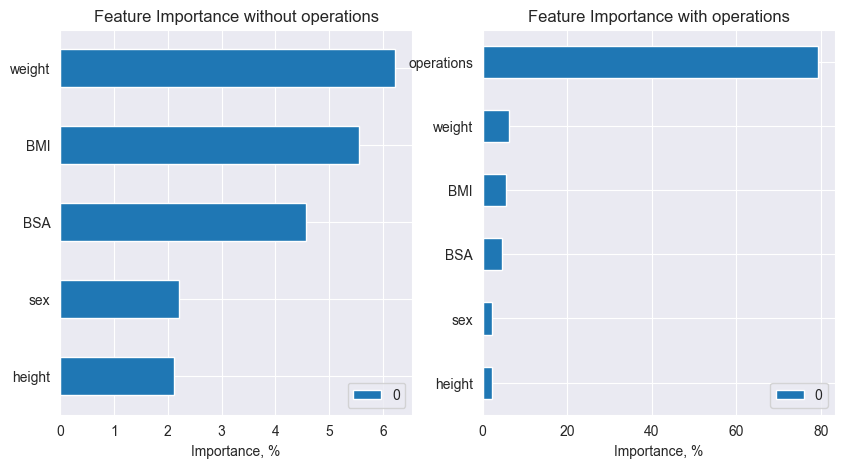

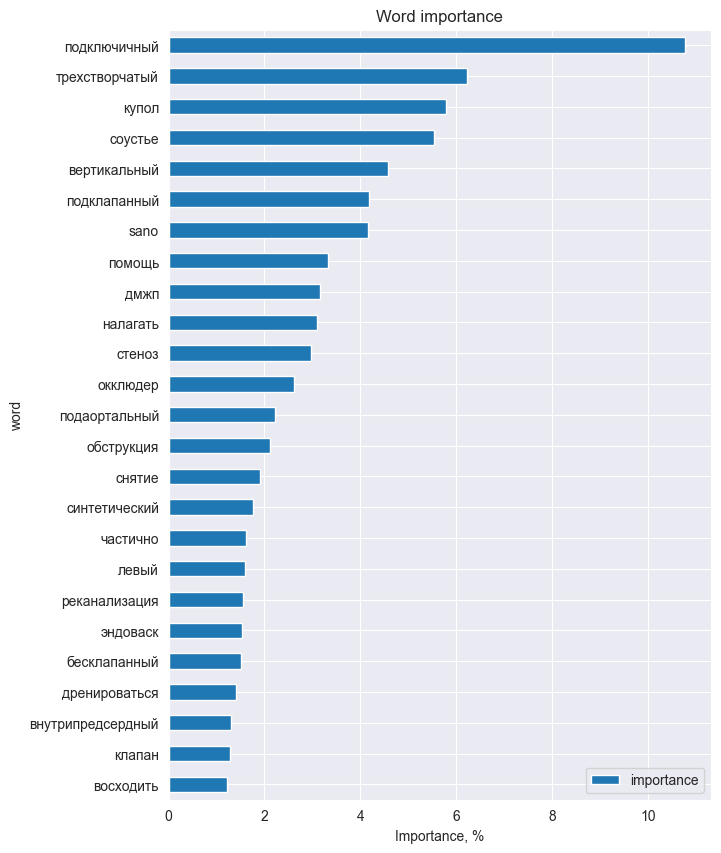

Threshold: 0.017
Confusion Matrix:
 [[67 19]
 [ 0  4]]
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        86
           1       0.17      1.00      0.30         4

    accuracy                           0.79        90
   macro avg       0.59      0.89      0.59        90
weighted avg       0.96      0.79      0.85        90



In [351]:
parameters = {
    'clf__iterations': range(100, 1000)
}

test = create_random_search(CatBoostClassifier(silent=True), parameters, make_scorer(roc_auc_score, labels=[1]), 3)#.fit(X, y)
best_model = fit_data(test)